<a href="https://colab.research.google.com/github/Nident/Calculator/blob/main/Kidney_stones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# download required modules
!pip install -q patchify
!pip install -q datasets
!pip install -q monai

In [ ]:
import numpy as np
import os
import re
import json
import matplotlib.pyplot as plt
import cv2, zlib, base64, io
from google.colab.patches import cv2_imshow
from patchify import patchify
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/JOB/Medicine
%ls
# unzip file with images and annotations to google colab drive
!unzip -qd "/content" "/content/drive/MyDrive/JOB/Medicine/Stone"
HOME = os.getcwd()
print("HOME:", HOME)

Mounted at /content/drive
/content/drive/MyDrive/JOB/Medicine
model_checkpoint.pth  Stone.zip  weights/
HOME: /content/drive/MyDrive/JOB/Medicine


# Read images from folder

In [ ]:
class Images_reader:
  def __init__(self, image_path, annotation_path) -> None:
    # self.full_data_dict = {}
    self.image_path = image_path # Path to image folder

    self.annotation_path = annotation_path # Path to annotation folder

    self.images = np.array([])
    self.masks = np.array([])

  @staticmethod
  def base64_2_mask(s: str) -> np.array:
    """
    Function convert numpy matrix into bitmap surevisely format

    Args:
        s (str): bitmap encoded string

    Returns:
        np.array: original object matrix
    """
    z = zlib.decompress(base64.b64decode(s))
    n = np.fromstring(z, np.uint8)
    mask = cv2.imdecode(n, cv2.IMREAD_UNCHANGED)[:, :, 3].astype(bool)

    return mask

  @staticmethod
  def mask_2_base64(mask: np.array) -> str:
    """
    Function convert bitmap surevisely format into numpy matrix

    Args:
        mask (np.array): original object matrix

    Returns:
        str: bitmap encoded string
    """
    img_pil = Image.fromarray(np.array(mask, dtype=np.uint8))
    img_pil.putpalette([0, 0, 0, 255, 255, 255])
    bytes_io = io.BytesIO()
    img_pil.save(bytes_io, format='PNG', transparency=0, optimize=0)
    bytes = bytes_io.getvalue()

    return base64.b64encode(zlib.compress(bytes)).decode('utf-8')

  def draw_mask(self, initial_matrix, image_annotation):
    # This function draw a mask for each image
    position = (image_annotation['objects'][0]['bitmap']['origin'][-1], \
                image_annotation['objects'][0]['bitmap']['origin'][0])

    # Convert object from bitamp to matrix
    bitmap_matrix = self.base64_2_mask(image_annotation['objects'][0]['bitmap']['data'])
    bitmap_size = bitmap_matrix.shape

    mask = np.zeros_like(initial_matrix[:, :, 0], dtype=np.uint8)

    mask[position[0] : position[0] + bitmap_size[0],
         position[1] : position[1] + bitmap_size[1]] = bitmap_matrix

    return mask


  def split_to_numpyis(self):
    # This function split images and masks in twon numpy arrays
    img_arrays = []
    mask_arrays = []

    images_list = os.listdir(self.image_path)
    # i = 0 # test
    for idx, img_jpg in enumerate(images_list):
      img = plt.imread(self.image_path + '/' + img_jpg)

      img_arrays += [np.array(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))]

      find_ann = (self.annotation_path + '/' + img_jpg).replace('jpg', 'bmp') + '.json'
      with open(find_ann, 'r') as f:
            image_annotation = json.load(f)
      mask = self.draw_mask(img, image_annotation) * 255
      mask_arrays += [mask]
      # if i == 1: # test
      #   break  # test
      # i += 1 # test
    self.images = np.stack(img_arrays)
    self.masks = np.stack(mask_arrays)
    return self.images, self.masks

In [ ]:
image_path = "/content/Stone/img"
annotation_path = "/content/Stone/ann"
reader = Images_reader(image_path, annotation_path)

In [ ]:
large_images, large_masks = reader.split_to_numpyis()
print(large_images.shape)
print(large_masks.shape)

<ipython-input-37-b02ea3c8c6c4>:24: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  n = np.fromstring(z, np.uint8)


(273, 1555, 1555)
(273, 1555, 1555)


In [ ]:
# split image to patches
def to_patches(large_images, large_masks):
    patch_size = 256
    step = 256
    all_img_patches = []
    for img in range(large_images.shape[0]):
        large_image = large_images[img]
        patches_img = patchify(large_image, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):

                single_patch_img = patches_img[i,j,:,:]
                all_img_patches.append(single_patch_img)

    patched_images = np.array(all_img_patches)

    #Let us do the same for masks
    all_mask_patches = []
    for img in range(large_masks.shape[0]):
        large_mask = large_masks[img]
        patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

        for i in range(patches_mask.shape[0]):
            for j in range(patches_mask.shape[1]):

                single_patch_mask = patches_mask[i,j,:,:]
                single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)
                all_mask_patches.append(single_patch_mask)

    patched_masks = np.array(all_mask_patches)
    return patched_images, patched_masks

In [ ]:
patched_images, patched_masks = to_patches(large_images, large_masks)
print(patched_images.shape)
print(patched_masks.shape)

(9828, 256, 256)
(9828, 256, 256)


In [ ]:
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(patched_masks) if mask.max() != 0]
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = patched_images[valid_indices]
filtered_masks = patched_masks[valid_indices]
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)

Image shape: (1233, 256, 256)
Mask shape: (1233, 256, 256)


In [ ]:
from datasets import Dataset
dataset_dict = {
    "image": [Image.fromarray(img).convert('RGB') for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

dataset = Dataset.from_dict(dataset_dict)

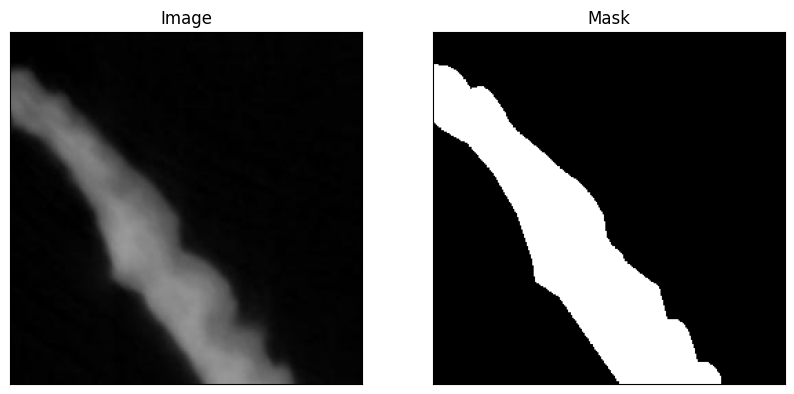

In [ ]:
img_num = np.random.randint(0, filtered_images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [ ]:
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [ ]:
from torch.utils.data import Dataset
class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)
    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")
    print(inputs)
    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}
    print(inputs)
    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [ ]:
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [ ]:
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [ ]:
example = train_dataset[0]
for k, v in example.items():
  print(k, v.shape)

{'pixel_values': tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.0837, -2.0837, -2.0837],
          [-2.1179, -2.1179, -2.1179,  ..., -2.0837, -2.0837, -2.0837],
          [-2.1179, -2.1179, -2.1179,  ..., -2.0837, -2.0837, -2.0837],
          ...,
          [-2.0837, -2.0837, -2.0837,  ..., -2.1179, -2.1179, -2.1179],
          [-2.0837, -2.0837, -2.0837,  ..., -2.1179, -2.1179, -2.1179],
          [-2.0837, -2.0837, -2.0837,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0007, -2.0007, -2.0007],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0007, -2.0007, -2.0007],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0007, -2.0007, -2.0007],
          ...,
          [-2.0007, -2.0007, -2.0007,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0007, -2.0007, -2.0007,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0007, -2.0007, -2.0007,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.7696, -1.7696, -1.7696],
          [-1

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

{'pixel_values': tensor([[[[-2.1008, -2.1008, -2.1008,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1008, -2.1008, -2.1008,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1008, -2.1008, -2.1008,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0182, -2.0182, -2.0182,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0182, -2.0182, -2.0182,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0182, -2.0182, -2.0182,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.7870, -1.7870, -1.7870,  ..., -1.8044, -1.8044, -1.8044],
          [-1

In [ ]:
from transformers import SamModel

model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [ ]:
from torch.optim import Adam
import monai

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

num_epochs = 2

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

In [ ]:
path to save model
torch.save(model.state_dict(), "/content/drive/MyDrive/JOB/Medicine/model_checkpoint.pth")

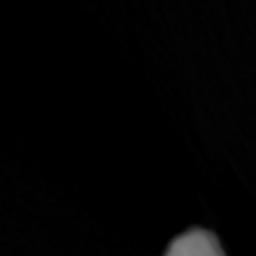

In [ ]:
import numpy as np
from PIL import Image

# let's take a random training example
idx = 0

# load image
image = dataset[idx]["image"]
image

In [ ]:
# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
for k,v in inputs.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])


In [ ]:
model.eval()

# forward pass
with torch.no_grad():
  outputs = model(**inputs, multimask_output=False)

In [ ]:
# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

(-0.5, 255.5, 255.5, -0.5)

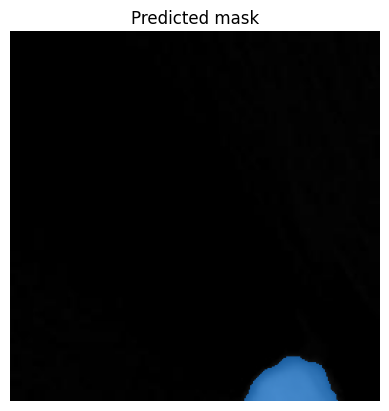

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(medsam_seg, axes)
axes.title.set_text(f"Predicted mask")
axes.axis("off")

(-0.5, 255.5, 255.5, -0.5)

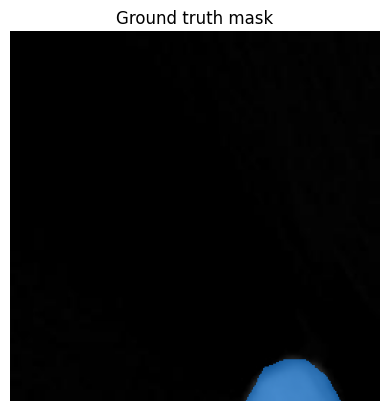

In [ ]:
fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(ground_truth_mask, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

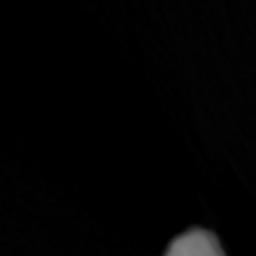

In [ ]:
(dataset[0]['image'])

# Run Saved Model

In [ ]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [ ]:
model_config = SamConfig.from_pretrained('facebook/sam-vit-base')
processor = SamProcessor.from_pretrained('facebook/sam-vit-base')

In [ ]:
my_mito_model = SamModel(config=model_config)
# use path to a save train model
my_mito_model.load_state_dict(torch.load('/content/drive/MyDrive/JOB/Medicine/model_checkpoint.pth'))

<ipython-input-31-255ee2c1167d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  my_mito_model.load_state_dict(torch.load('/content/drive/MyDrive/JOB/Medicine/model_checkpoi

<All keys matched successfully>

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
my_mito_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

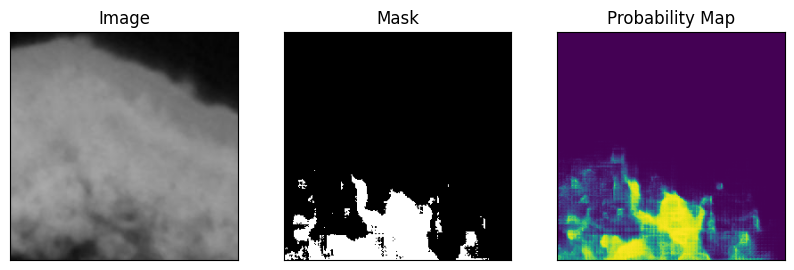

In [ ]:
idx = np.random.randint(0, filtered_images.shape[0]-1)
test_image = dataset[idx]['image']

ground_truth_mask = np.array(dataset[idx]['label'])
prompt = get_bounding_box(ground_truth_mask)

inputs = processor(test_image, input_boxes=[[prompt]], return_tensors='pt')

inputs = {k: v.to(device) for k, v in inputs.items()}
my_mito_model.eval()

with torch.no_grad():
  outputs = my_mito_model(**inputs, multimask_output=False)

medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()